# HyperStyle Domain Adaptation Notebook

In the paper, we show that the weight offsets predicted by HyperStyle over the FFHQ domain are also applicable on fine-tuned generators such as toonify and StyleGAN-NADA. We demonstrate this idea below.

## Prepare Environment and Download HyperStyle Code

In [1]:
#@title Clone HyperStyle Repo and Install Ninja { display-mode: "form" } 
import os
# os.chdir('./')
CODE_DIR = './'

## clone repo
# !git clone https://github.com/yuval-alaluf/hyperstyle.git $CODE_DIR

## install ninja
# !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
# !sudo unzip ninja-linux.zip -d /usr/local/bin/
# !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

os.chdir(f'./{CODE_DIR}')

In [2]:
#@title Import Packages { display-mode: "form" }
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

# from notebooks.notebook_utils import Downloader, HYPERSTYLE_PATHS, W_ENCODERS_PATHS, FINETUNED_MODELS, RESTYLE_E4E_MODELS, run_alignment

from notebooks.notebook_utils import HYPERSTYLE_PATHS, W_ENCODERS_PATHS, FINETUNED_MODELS, RESTYLE_E4E_MODELS, run_alignment

from utils.common import tensor2im
from utils.inference_utils import run_inversion
from utils.domain_adaptation_utils import run_domain_adaptation
from utils.model_utils import load_model, load_generator

%load_ext autoreload
%autoreload 2

## Define Download Configuration
Select below whether you wish to download all models using `pydrive`. Note that if you do not use `pydrive`, you may encounter a "quota exceeded" error from Google Drive.

In [3]:
# #@title Download Configuration { display-mode: "form" }
# download_with_pydrive = True #@param {type:"boolean"}
# downloader = Downloader(code_dir=CODE_DIR, use_pydrive=download_with_pydrive)

## Define Fine-tuned Generator Type

In [4]:
#@title { display-mode: "form" }
generator_type = 'toonify' #@param ['toonify', 'pixar', 'sketch', 'disney_princess']

## Define and Download All Models

In [5]:
#@title Download HyperStyle model { display-mode: "form" }
hyperstyle_path = "./pretrained_models/hyperstyle_ffhq.pt" #@param {type:"string"}
w_encoder_path = "./pretrained_models/faces_w_encoder.pt" #@param {type:"string"}


if not os.path.exists(hyperstyle_path) or os.path.getsize(hyperstyle_path) < 1000000:
    print(f'Downloading HyperStyle model for faces...')
    downloader.download_file(file_id=HYPERSTYLE_PATHS["faces"]['id'], file_name=HYPERSTYLE_PATHS["faces"]['name'])
    # if google drive receives too many requests, we'll reach the quota limit and be unable to download the model
    if os.path.getsize(hyperstyle_path) < 1000000:
        raise ValueError("Pretrained model was unable to be downloaded correctly!")
    else:
        print('Done.')
else:
    print(f'HyperStyle model for faces already exists!')

if not os.path.exists(w_encoder_path) or os.path.getsize(w_encoder_path) < 1000000:
    print(f'Downloading the WEncoder model for faces...')
    downloader.download_file(file_id=W_ENCODERS_PATHS["faces"]['id'], file_name=W_ENCODERS_PATHS["faces"]['name'])
    # if google drive receives too many requests, we'll reach the quota limit and be unable to download the model
    if os.path.getsize(w_encoder_path) < 1000000:
        raise ValueError("Pretrained model was unable to be downloaded correctly!")
    else:
        print('Done.')
else:
    print(f'WEncoder model for faces already exists!')

net, opts = load_model(hyperstyle_path, update_opts={"w_encoder_checkpoint_path": w_encoder_path})
print('Model successfully loaded!')
pprint.pprint(vars(opts))

HyperStyle model for faces already exists!
WEncoder model for faces already exists!


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/fei/svo0175/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



Loading HyperStyle from checkpoint: ./pretrained_models/hyperstyle_ffhq.pt
Loading pretrained W encoder...
Using WEncoder
Loading WEncoder from checkpoint: ./pretrained_models/faces_w_encoder.pt
Model successfully loaded!
{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': './pretrained_models/hyperstyle_ffhq.pt',
 'dataset_type': 'ffhq_hypernet',
 'device': 'cuda:0',
 'encoder_type': 'SharedWeightsHyperNetResNet',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 6,
 'l2_lambda': 1.0,
 'layers_to_tune': '5,6,8,9,11,12,14,15,17,18,20,21,23,24',
 'learning_rate': 0.0001,
 'load_w_encoder': True,
 'lpips_lambda': 0.8,
 'max_steps': 500000,
 'max_val_batches': 150,
 'moco_lambda': 0,
 'n_hypernet_outputs': 26,
 'n_iters_per_batch': 5,
 'optim_name': 'ranger',
 'output_size': 1024,
 'save_interval': 10000,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 8,
 'train_decoder': False,
 'val_interval': 5000,
 'w_encoder_checkpoint_path': './pretr

In [6]:
#@title Download Fine-tuned Generator { display-mode: "form" }
generator_path = f"./pretrained_models/{FINETUNED_MODELS[generator_type]['name']}"

if not os.path.exists(generator_path):
    print(f'Downloading fine-tuned {generator_type} generator...')
    downloader.download_file(file_id=FINETUNED_MODELS[generator_type]["id"], 
                             file_name=FINETUNED_MODELS[generator_type]['name'])
    print('Done.')
else:
    print(f'Fine-tuned {generator_type} generator already exists!')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

fine_tuned_generator = load_generator(generator_path)
print(f'Fine-tuned {generator_type} generator successfully loaded!')

Fine-tuned toonify generator already exists!
Loading generator from checkpoint: ./pretrained_models/toonify.pt
Fine-tuned toonify generator successfully loaded!


In [7]:
#@title Download ReStyle-e4e Model { display-mode: "form" }

restyle_e4e_path = os.path.join("./pretrained_models", RESTYLE_E4E_MODELS['name'])

if not os.path.exists(restyle_e4e_path):
    print('Downloading ReStyle-e4e model...')
    downloader.download_file(file_id=RESTYLE_E4E_MODELS["id"], file_name=RESTYLE_E4E_MODELS["name"])
    print('Done.')
else:
    print('ReStyle-e4e model already exists!')

restyle_e4e, restyle_e4e_opts = load_model(restyle_e4e_path, is_restyle_encoder=True)
print(f'ReStyle-e4e model successfully loaded!')

ReStyle-e4e model already exists!
Loading ReStyle e4e from checkpoint: ./pretrained_models/restlye_e4e.pt
ReStyle-e4e model successfully loaded!


Done.
Finished running alignment on image: ./notebooks/images/domain_adaptation.jpg


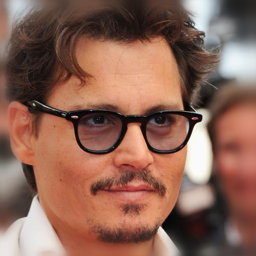

In [8]:
#@title Download (And Align) Image { display-mode: "form" }

image_path = "./notebooks/images/domain_adaptation.jpg" #@param {type:"string"}
# image_path = "./notebooks/images/foto3.jpg" #@param {type:"string"}

input_is_aligned = False #@param {type:"boolean"}
if not input_is_aligned:
    input_image = run_alignment(image_path)
else:
    input_image = Image.open(image_path).convert("RGB")

input_image.resize((256, 256))

## Run Inference

In [9]:
#@title { display-mode: "form" } 
img_transforms = transforms.Compose([transforms.Resize((256, 256)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transformed_image = img_transforms(input_image)

restyle_e4e_opts.n_iters_per_batch = 5
restyle_e4e_opts.resize_outputs = False
opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution

with torch.no_grad():
    tic = time.time()
    result, _ = run_domain_adaptation(transformed_image.unsqueeze(0).cuda(), 
                                      net, 
                                      opts, 
                                      fine_tuned_generator, 
                                      restyle_e4e, 
                                      restyle_e4e_opts)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 1.0966 seconds.


## Visualize Result

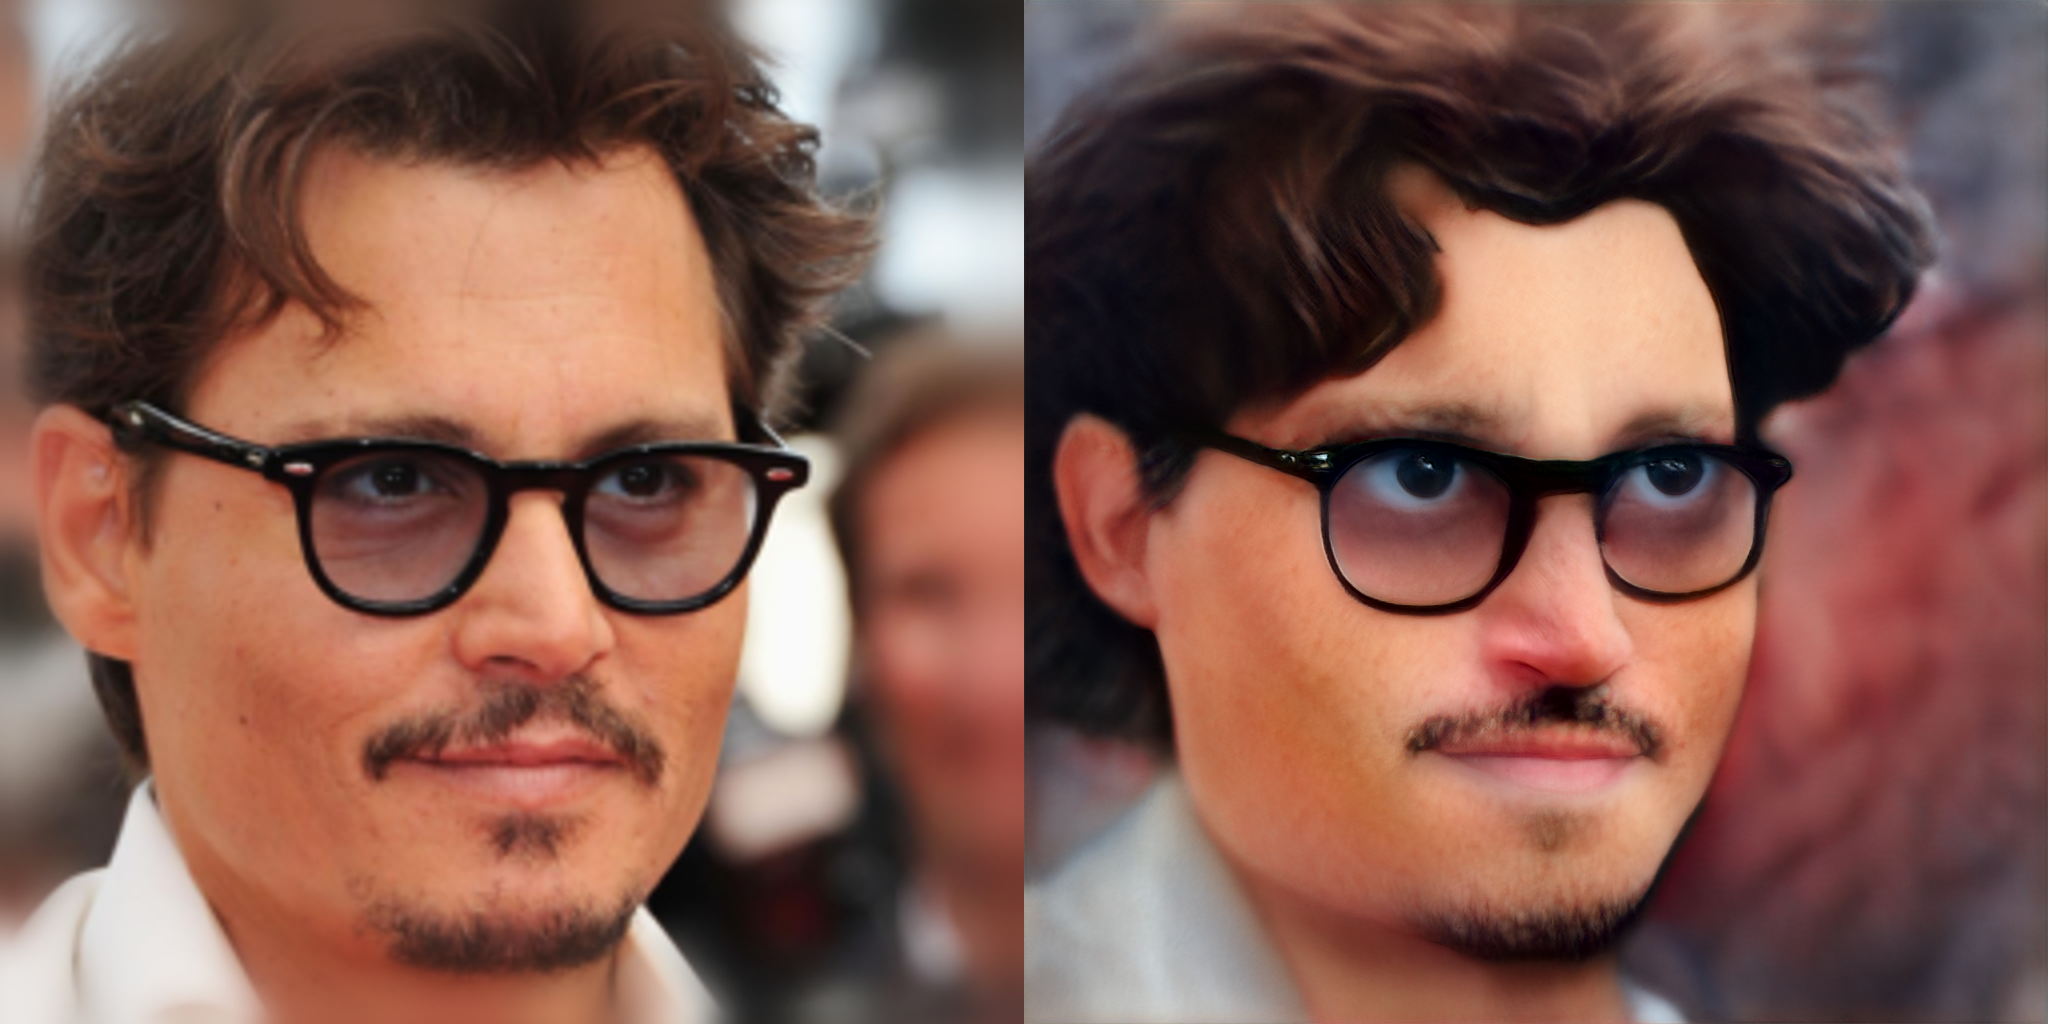

In [10]:
#@title { display-mode: "form" } 
resize_amount = (256, 256) if opts.resize_outputs else (opts.output_size, opts.output_size)

final_res = tensor2im(result[0]).resize(resize_amount)
input_im = tensor2im(transformed_image).resize(resize_amount)
res = np.concatenate([np.array(input_im), np.array(final_res)], axis=1)
res = Image.fromarray(res)
res

## Save Result

In [11]:
#@title { display-mode: "form" } 
outputs_path = f"./outputs/domain_adaptation/{generator_type}"
os.makedirs(outputs_path, exist_ok=True)
res.save(os.path.join(outputs_path, os.path.basename(image_path)))